## Enunciado questão
A financeira FMG realiza mensalmente a concessão de crédito pessoal para seus clientes. Para manter a saúde financeira de suas operações, a taxa de inadimplência esperada de cada safra 6 meses após a concessão não pode ser superior a 5,0%.
Foi solicitado que você realize uma revisão na política atual de concessão. Para realizar esta tarefa, foram fornecidos os dados de clientes de 5 meses que realizaram contratações de crédito entre janeiro e maio de 2022 (aba "DADOS"), com a indicação de quem esteve inadimplente no contrato 6 meses após a contratação. A sugestão inicial é que a política de crédito considere que as aprovações de propostas acontecem considerando o score de crédito dos clientes, sendo que clientes com score superior a 600 são aprovados, e clientes com score até 500 são negados.

Considerando as informações acima, a política de crédito inicialmente sugerida é eficiente? É possível aumentar a concessão sem ferir o apetite de inadimplência?
Caso entenda não ser eficiente, elabore uma nova proposta de política para apresentar à gestão do FMG. 


In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings

warnings.filterwarnings("ignore") 

# pd.set_option()

# https://medium.com/@natalia.gcvs/regress%C3%A3o-log%C3%ADstica-uma-vis%C3%A3o-geral-de-uma-t%C3%A9cnica-de-classifica%C3%A7%C3%A3o-bin%C3%A1ria-eba0a4a06518
# 1 = indadimplente (evento)
# 0 = adimplente (nao evento)
# fazer quantidade de operações por mês como analise descritiva também ( da para fazer um grafico)
# quantidade de operações por genero, localizacao...
# https://www.youtube.com/watch?v=lK8ANM7VkNU , ideia de fazer um novo score-credito

# Importação e tratamento dos dados

In [26]:
df = pd.read_excel('dados_case.xlsx', sheet_name='dados')
df2 = df.copy()
df2.head(10)

df2['Safra'] = pd.to_datetime(df2['Safra'].astype(str), format='%Y%m')
df2['Safra'] = df2['Safra'].dt.strftime('%Y-%m-%d') 

for i in df.columns:
    resultado = df2[i].isna().unique()
    print(f"'{i}' apresenta valores faltantes: {resultado}")

'Cliente' apresenta valores faltantes: [False]
'Safra' apresenta valores faltantes: [False]
'idade' apresenta valores faltantes: [False]
'genero' apresenta valores faltantes: [False]
'renda' apresenta valores faltantes: [False]
'Score_de_credito' apresenta valores faltantes: [False]
'localizacao' apresenta valores faltantes: [False]
'nivel_escolaridade' apresenta valores faltantes: [False]
'contas_bancarias' apresenta valores faltantes: [False]
'Contratos' apresenta valores faltantes: [False]
'Faixa_renda' apresenta valores faltantes: [False]
'Faixa_idade' apresenta valores faltantes: [False]
'Faixa_Score' apresenta valores faltantes: [False]
'Atraso_apos_6meses' apresenta valores faltantes: [False]


# Sem correlação nas variáveis independentes, ou seja, sem multicolinearidade

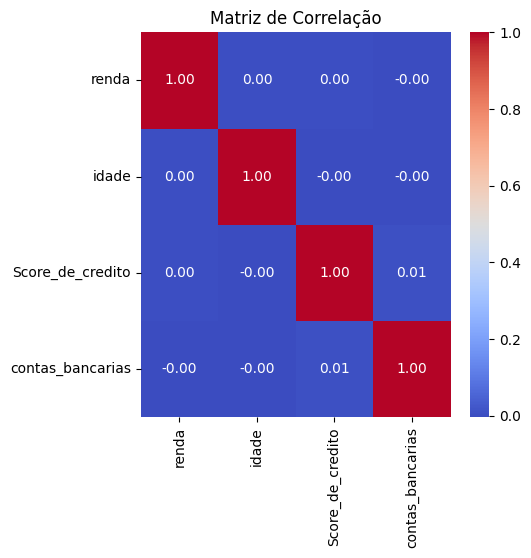

In [140]:
matriz = df2[['renda','idade','Score_de_credito','contas_bancarias']].corr()
plt.figure(figsize=(5,5))
sns.heatmap(matriz, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

# Análise da Taxa de Inadimplência Atual
### Considerando atraso apos 6 meses de contrato:
.: Taxa de 6.65%, portanto superior a 5% concluindo que está prejudicial para a saúde operacional da empresa.


In [141]:
total_linhas = len(df2)
total_atraso = len(df2[df2['Atraso_apos_6meses']==1])

tx_atual = total_atraso/total_linhas

print(f"Taxa de inadimplencia hoje: {tx_atual*100}%")

Taxa de inadimplencia hoje: 6.65%


### Considerando o score de crédito
 - maior que 600 = aprovado
 - menor ou igual a 500 = nao aprovado

In [142]:
tx_df2_600 = len(df2[(df2['Score_de_credito']>600) & (df2['Atraso_apos_6meses']==1)]) / len(df2[(df2['Score_de_credito']>600)])
tx_df2_500 = len(df2[(df2['Score_de_credito']<=500) & (df2['Atraso_apos_6meses']==1)]) / len(df2[(df2['Score_de_credito']<=500)])


print(f"Taxa de inadimplencia com score acima de 600: {tx_df2_600 * 100} %")
print(f"Taxa de inadimplencia com score 500 ou menor: {tx_df2_500 * 100} %")

Taxa de inadimplencia com score acima de 600: 4.871122761031018 %
Taxa de inadimplencia com score 500 ou menor: 8.596300326441785 %


Esses dados indicam que, conforme a pontuação de crédito do cliente aumenta, a taxa de inadimplência diminui, o que é esperado em muitos modelos de concessão de crédito. Isso sugere que a política atual (aprovando clientes com score superior a 600 e negando os com score abaixo de 500) pode ser razoavelmente eficiente.

# Nova política de crédito

# Reg Logística

In [78]:
# colunas numéricas e categóricas
numeric_features   = ['contas_bancarias']
categorical_feats  = ['genero', 'localizacao', 'nivel_escolaridade', 'Faixa_renda', 'Faixa_idade', 'Faixa_Score']

# Monte o “pipeline” de pré-processamento
preprocessor = ColumnTransformer([
    ('n', MinMaxScaler(), numeric_features),
    ('c', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), categorical_feats),
])

# treino e teste
X = df2[numeric_features + categorical_feats]
y = df2['Atraso_apos_6meses']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, stratify=y
)

# pré-processador só com os dados de treino
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# nomes das variáveis transformadas
feat_names = preprocessor.get_feature_names_out()

# Tabela resumo para statsmodels e intercepto
X_train_sm = pd.DataFrame(X_train_proc, columns=feat_names, index=X_train.index)
X_train_sm = sm.add_constant(X_train_sm)

# modelo Logit
logit_sm = sm.Logit(y_train, X_train_sm).fit(disp=False)

# coeficientes e p-valores
logit_sm.summary2().tables[1]


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-2.375943,0.230671,-10.300124,7.037047e-25,-2.828050,-1.923835
n__contas_bancarias,-0.081069,0.128323,-0.631752,5.275486e-01,-0.332578,0.170441
c__genero_Masculino,0.093179,0.090397,1.030774,3.026469e-01,-0.083996,0.270355
c__localizacao_Norte,0.085755,0.150528,0.569697,5.688833e-01,-0.209274,0.380784
c__localizacao_Oeste,0.055821,0.140213,0.398113,6.905466e-01,-0.218992,0.330633
c__localizacao_Sul,0.019600,0.160282,0.122286,9.026723e-01,-0.294546,0.333747
c__nivel_escolaridade_Médio,-0.002616,0.128063,-0.020430,9.837004e-01,-0.253616,0.248383
c__nivel_escolaridade_Pós-graduação,-0.422539,0.112469,-3.756922,1.720162e-04,-0.642975,-0.202103
c__nivel_escolaridade_Superior,-0.244369,0.146913,-1.663363,9.623986e-02,-0.532313,0.043575
c__Faixa_renda_4001-6000,-0.198285,0.134464,-1.474624,1.403137e-01,-0.461830,0.065261


### Coeficientes Significativos (p-valor < 0.05):
**Score_de_credito**: Coeficiente -0.283049 com valor p 1.14e-08. A variável Score_de_credito tem um impacto significativo na probabilidade de inadimplência. Quanto maior o score de crédito, menor a probabilidade de inadimplência, o que está de acordo com a política atual. Isso confirma que o score de crédito é um bom preditor de inadimplência.

**nivel_escolaridade_Pós-graduação**: Coeficiente -0.422539 com valor p 1.72e-04. Indivíduos com nível de escolaridade pós-graduação têm uma probabilidade significativamente menor de inadimplência em comparação com os demais. Portanto, a escolaridade pode ser uma variável importante a ser considerada na política de crédito.

**nivel_escolaridade_Superior**: Coeficiente -0.244369 com valor p 0.09. Embora o valor p esteja ligeiramente acima de 0.05, ainda assim o coeficiente negativo sugere que clientes com nível superior têm menos chances de inadimplência, mas essa variável tem menos significância estatística do que a variável Pós-graduação.

**Faixa_Score_601-700**, **Faixa_Score_701-800**, e **Faixa_Score_801-850**: Todos têm coeficientes negativos e valores p significativos. Isso confirma que faixas de score mais altas estão associadas a menos inadimplência.


In [108]:
# Para rodar predições e avaliar no teste:
X_test_sm = pd.DataFrame(X_test_proc, columns=feat_names, index=X_test.index)
X_test_sm = sm.add_constant(X_test_sm)
y_pred_proba = logit_sm.predict(X_test_sm)

corte = 0.1
y_pred = (y_pred_proba >= corte).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Matriz de Confusão:")
print(conf_matrix)

print("Threshold:")
print(corte)

precision = precision_score(y_test, y_pred)
print(f"Precisão: {precision:.2f}")

recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.2f}")

Matriz de Confusão:
[[1681  186]
 [ 106   27]]
Threshold:
0.1
Precisão: 0.13
Recall: 0.20


### Comparação das políticas

**Política Atual**:
- Aprovação para clientes com score de crédito superior a 600.
- Recusa para clientes com score de crédito igual ou abaixo de 500.

Pode-se ajustá-la levando em conta outras variáveis significativas identificadas na análise.

**Política Proposta**:
- Considerar mais faixas de score:
    - Para clientes com score de 601-700, 701-800, e 801-850, a probabilidade de inadimplência é mais baixa, e esses clientes podem ser mais facilmente aprovados com menor risco de inadimplência.
    - Isso sugere que a política de aprovados com score acima de 600 poderia ser expandida para incluir faixas adicionais.

- Considerar o nível de escolaridade:
    - Clientes com pós-graduação apresentam uma probabilidade significativamente menor de inadimplência, portanto, podem ser priorizados na concessão de crédito.
    - Clientes com nível superior também mostram uma tendência a pagar suas dívidas com mais frequência, e podem ser incluídos em uma faixa de risco menor.

## Ajuste do Threshold
A relação entre o ajuste do corte (threshold) e a política de crédito de um banco está diretamente ligada à decisão de conceder crédito (ou não) a um cliente, e isso impacta diretamente a precisão (precision) e o recall do modelo. 

Exemplo: Se o threshold for 0.5:

- Se a probabilidade de inadimplência de um cliente for maior ou igual a 0.5, o modelo classifica como inadimplente (1).
- Se for menor que 0.5, classifica como não inadimplente (0).

Mas o threshold pode ser ajustado. Por exemplo:

Threshold baixo (Banco mais conservador):
- Aumento do Recall: Mais clientes inadimplentes serão identificados.
- Redução da Precisão: O banco pode erroneamente aprovar mais clientes como inadimplentes, aumentando a taxa de falsos positivos (clientes não inadimplentes classificados como inadimplentes).

Threshold alto (Banco arriscando mais):
- Aumento da Precisão: Menos clientes serão classificados como inadimplentes, aumentando a precisão porque as previsões positivas do modelo serão mais confiáveis.
- Redução do Recall: O modelo pode deixar de identificar alguns inadimplentes reais (aumentando os falsos negativos).


### Conclusão / Melhorias
- Incorporando variáveis adicionais como faixas de score e nível de escolaridade, pode-se aumentar a concessão de crédito sem aumentar o risco de inadimplência.
- Análises adicionais podem ser feitas para refinar ainda mais o modelo e garantir que as variáveis mais impactantes (como faixas de score e escolaridade) sejam priorizadas.

# OLS

In [70]:
# 1) Defina colunas numéricas e categóricas
numeric_features   = ['contas_bancarias']
categorical_feats  = ['genero', 'localizacao', 'nivel_escolaridade','Faixa_renda', 'Faixa_idade', 'Faixa_Score']

# 2) Monte o pré-processador
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), numeric_features),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'),
    categorical_feats),
])

# 3) Separe X e y (target contínuo: Score_de_credito)
X = df2[numeric_features + categorical_feats]
y = df2['Score_de_credito']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

# 4) Aplique o pré-processador
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

# 5) Recupere nomes das variáveis transformadas
feat_names = preprocessor.get_feature_names_out()

# 6) Monte DataFrame para statsmodels e adicione intercepto
X_train_sm = pd.DataFrame(X_train_proc, columns=feat_names, index=X_train.index)
X_train_sm = sm.add_constant(X_train_sm)

# 7) Ajuste do modelo OLS
ols_sm = sm.OLS(y_train, X_train_sm).fit()

# 8) Exiba o summary com coeficientes, erros-padrão, t-stats e p-valores
print(ols_sm.summary2())

                             Results: Ordinary least squares
Model:                      OLS                     Adj. R-squared:            0.969     
Dependent Variable:         Score_de_credito        AIC:                       75960.4576
Date:                       2025-06-20 14:39        BIC:                       76100.2016
No. Observations:           8000                    Log-Likelihood:            -37960.   
Df Model:                   19                      F-statistic:               1.325e+04 
Df Residuals:               7980                    Prob (F-statistic):        0.00      
R-squared:                  0.969                   Scale:                     776.41    
-----------------------------------------------------------------------------------------
                                       Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
-----------------------------------------------------------------------------------------
const                                 4

# Inputando novos clientes e tentando prever o score_credito

In [ ]:
novo_cliente = pd.DataFrame([{
    'contas_bancarias':    1,
    'genero':             'Masculino',
    'localizacao':        'Sul',
    'nivel_escolaridade': 'Médio',
    'Faixa_renda':        '6001-10000',
    'Faixa_idade':        '36-50',
    'Faixa_Score':        '801-850'
}])

X_novo_proc = preprocessor.transform(novo_cliente)

X_novo_df = pd.DataFrame(X_novo_proc, columns=feat_names, index=novo_cliente.index)
X_novo_df = sm.add_constant(X_novo_df, has_constant='add')

score_predito = ols_sm.predict(X_novo_df)
print(f"Score previsto: {score_predito.iloc[0]:.2f}")

# Comparando modelos

In [104]:
df = pd.read_excel('dados_case.xlsx', sheet_name='dados')

# 1) Defina X, y:
X = df.drop(columns=['Cliente','Safra','Atraso_apos_6meses'])
y = df['Atraso_apos_6meses']

# 2) Colunas
# num_feats = ['idade','renda','Score_de_credito','contas_bancarias','Contratos']
num_feats = ['contas_bancarias','Contratos']
cat_feats = ['genero','localizacao','nivel_escolaridade','Faixa_renda','Faixa_idade','Faixa_Score']

preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), num_feats),
    ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), cat_feats),
])

corte = 0.3


# Modelos
models = {
    'Logit_balanced': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs'))
    ]),
    'RF_balanced': Pipeline([
        ('prep', preprocessor),
        ('clf', RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42))
    ]),
    'XGB': Pipeline([
        ('prep', preprocessor),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y)-y.sum())/y.sum()))
    ]),
}

# Recriar a validação cruzada com threshold ajustado
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Ajuste do threshold
threshold = 0.3  # Altere este valor conforme necessário

# Modelos
models = {
    'Logit_balanced': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs'))
    ]),
    'RF_balanced': Pipeline([
        ('prep', preprocessor),
        ('clf', RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42))
    ]),
    'XGB': Pipeline([
        ('prep', preprocessor),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y)-y.sum())/y.sum()))
    ]),
}

resultados = {}
for name, modelo in models.items():
    validacao_cruzada = cross_validate(modelo, X, y, cv=folds, scoring='roc_auc', return_train_score=False)

    # Prever as probabilidades
    modelo.fit(X, y)  # Fit the model (ajustar o modelo com os dados)
    y_pred_proba = modelo.predict_proba(X)[:, 1]  # Obtém as probabilidades para a classe positiva (1)

    # Ajustar para o threshold
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Calcular outras métricas como precisão e recall
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)

    resultados[name] = {
        'ROC AUC': validacao_cruzada['test_score'].mean(),
        'Precision': precision,
        'Recall': recall
    }

# Exibir os resultados
print("Modelo           ROC AUC    Precision    Recall")
for name in ['Logit_balanced', 'RF_balanced', 'XGB']:
    metricas = resultados[name]
    print(f"{name:<15} {metricas['ROC AUC']:.2f}    {metricas['Precision']:.2f}    {metricas['Recall']:.2f}")# Recriar a validação cruzada com threshold ajustado
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Ajuste do threshold
corte = 0.1  

# Modelos
models = {
    'Logit_balanced': Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs'))
    ]),
    'RF_balanced': Pipeline([
        ('prep', preprocessor),
        ('clf', RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42))
    ]),
    'XGB': Pipeline([
        ('prep', preprocessor),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y)-y.sum())/y.sum()))
    ]),
}

resultados = {}
for name, modelo in models.items():
    validacao_cruzada = cross_validate(modelo, X, y, cv=folds, scoring='roc_auc', return_train_score=False)

    modelo.fit(X, y) 
    y_pred_proba = modelo.predict_proba(X)[:, 1]

    # Ajustar para o threshold
    y_pred = (y_pred_proba >= corte).astype(int)

    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)

    resultados[name] = {
        'ROC AUC': validacao_cruzada['test_score'].mean(),
        'Precision': precision,
        'Recall': recall}

# Validacao
print("Modelo   ROC AUC Precision Recall")
for name in ['Logit_balanced', 'RF_balanced', 'XGB']:
    metricas = resultados[name]
    print(f"{name:<15} "
            f"{metricas['ROC AUC']:.2f}   "
            f"{metricas['Precision']:.2f}   "
            f"{metricas['Recall']:.2f}")

Modelo           ROC AUC    Precision    Recall
Logit_balanced  0.60    0.07    1.00
RF_balanced     0.52    0.46    1.00
XGB             0.52    0.19    1.00
Modelo   ROC AUC Precision Recall
Logit_balanced  0.60   0.07   1.00
RF_balanced     0.52   0.40   1.00
XGB             0.52   0.11   1.00


# Ajustando modelo de acordo com política

Métricas de Avaliação
1. Acurácia (Accuracy): 93%
Acurácia é a proporção de previsões corretas (verdadeiros positivos e verdadeiros negativos) sobre o total de previsões. Uma acurácia de 93% indica que o modelo acertou 93% das previsões, mas isso pode ser enganoso quando as classes são desbalanceadas.

2. CI de 95% (Intervalo de Confiança): (0.9203, 0.9389)
Este é o intervalo de confiança para a acurácia do modelo, que indica que, com 95% de certeza, a verdadeira acurácia do modelo está entre 92.03% e 93.89%.

3. No Information Rate (NIR): 93%
A No Information Rate (NIR) é a acurácia que você obteria ao simplesmente prever a classe mais prevalente em todos os casos. Ou seja, se você sempre prevesse a classe 0 (não inadimplente), a NIR seria de 93%.

O P-Value [Acc > NIR] de 0.5184 sugere que a acurácia do modelo não é estatisticamente superior à NIR, ou seja, o modelo pode não estar adicionando valor substancial em relação a sempre prever 0 (não inadimplente).

4. Kappa: 0
Kappa mede a acordo entre as previsões do modelo e os valores reais, levando em conta o que seria esperado por acaso. O valor 0 indica que o modelo não está melhor do que uma previsão aleatória.

5. Mcnemar's Test P-Value: <2e-16
O teste de McNemar é usado para verificar se o modelo tem um desbalanceamento nas classificações (i.e., se o modelo tende a prever uma classe de forma sistemática, mas não outra). O valor p extremamente pequeno (<2e-16) sugere que o modelo tem um viés claro em suas previsões (provavelmente devido ao desbalanceamento de classes).

Métricas de Classificação
6. Sensibilidade (Sensitivity): 1.00
Sensibilidade (também conhecida como recall ou true positive rate) mede a proporção de verdadeiros positivos corretamente identificados pelo modelo. Uma sensibilidade de 1.00 significa que o modelo identificou corretamente todos os casos de inadimplência (não houve falsos negativos).

7. Especificidade (Specificity): 0.00
Especificidade (também conhecida como true negative rate) mede a proporção de verdadeiros negativos corretamente identificados pelo modelo. Uma especificidade de 0.00 significa que o modelo não conseguiu identificar corretamente nenhum caso de não inadimplência (houve falsos positivos em todos os casos).

8. Valor Preditivo Positivo (Pos Pred Value): 0.93
Pos Pred Value (Precisão) mede a proporção de previsões positivas que são realmente positivas. Ou seja, em 93% das vezes que o modelo previu que o cliente seria inadimplente, ele estava correto.